In [3]:
!pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.3 MB/s eta 0:00:001.6 MB/s eta 0:00:01


In [2]:
import os, pickle, glob, math
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths
from tensorflow.keras import Sequential, layers
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from lab_2_helpers import *

In [ ]:
!tar -xJf captcha-images.tar.xz

In [3]:
# Dataset images folder
CAPTCHA_IMAGE_FOLDER = "./captcha-images"

# List of all the captcha images we need to process
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
# Review image paths
pprint(captcha_image_paths[:10])

['./captcha-images/G5P5.png',
 './captcha-images/5VXL.png',
 './captcha-images/4NL5.png',
 './captcha-images/4GGZ.png',
 './captcha-images/G7J9.png',
 './captcha-images/E6M8.png',
 './captcha-images/7WPB.png',
 './captcha-images/5TN5.png',
 './captcha-images/L6US.png',
 './captcha-images/2A5R.png']


Note that for each image, its file name (without extension) happens to be its corresponding CAPTCHA text. Thus, we extract file names for all CAPTCHA images and save them as labels for future use:

In [4]:
def extract_captcha_text(image_path):
    """ Extract correct CAPTCHA texts from file name of images. """
    # Extract file name of image from its path
    # e.g. "./captcha-images/2A2X.png" -> "2A2X.png"
    image_file_name = os.path.basename(image_path)
    # Extract base name of image, omitting file extension
    # e.g. "2A2X.png" -> "2A2X"
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]
# Review extraction results
pprint(captcha_texts[:10])

['G5P5', '5VXL', '4NL5', '4GGZ', 'G7J9', 'E6M8', '7WPB', '5TN5', 'L6US', '2A5R']


## Loading and Transforming Images
For the feature extraction stage, we are going to extract individual characters from these CAPTCHAs. This is done by looking for contours (bounding boxes) around characters, then cropping the CAPTCHAs such as only the contour areas are preserved. We begin feature extraction by loading and transforming images:

Figure(2000x500)


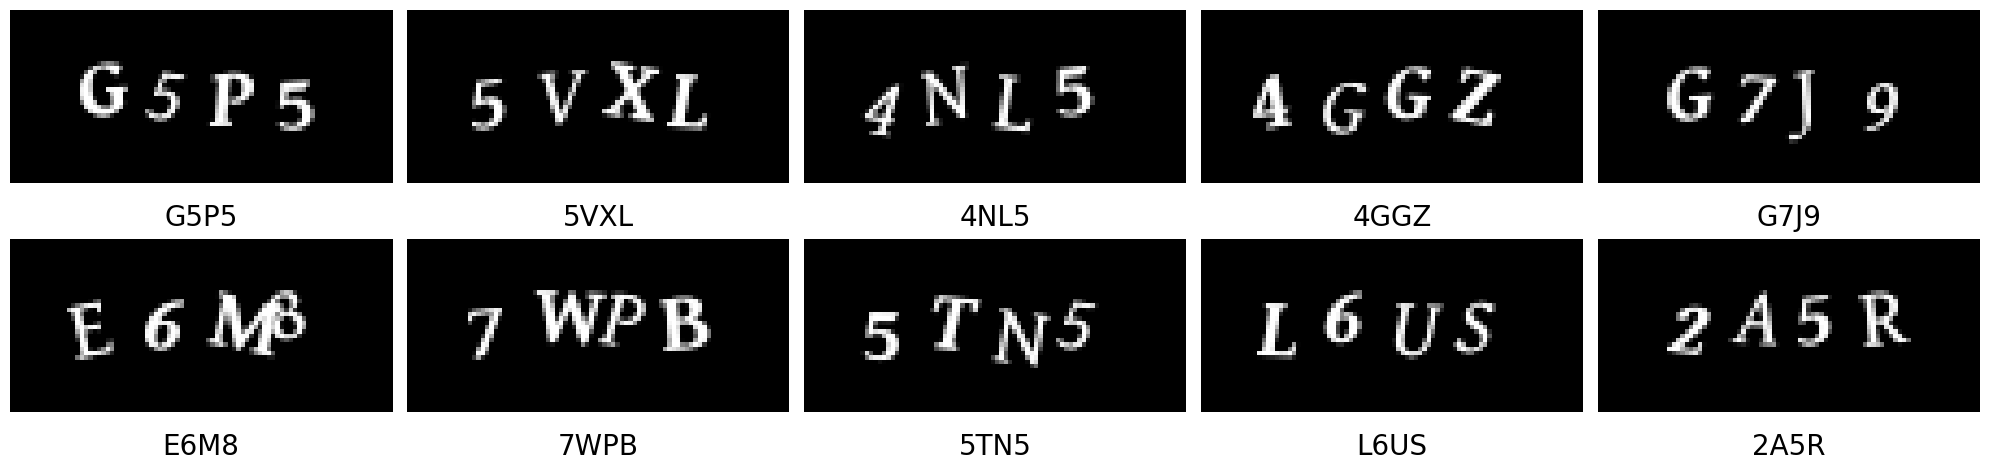

In [5]:
import cv2

def load_transform_image(image_path):
    """ Load and transform image into grayscale. """
    # 1) Load image with OpenCV
    image = cv2.imread(image_path)

    # 2) Convert image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 3) Add extra padding (8px) around the image
    image_padded = cv2.copyMakeBorder(image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    return image_padded

captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]
# Review loaded CAPTCHAs
print_images(
    captcha_images[:10], n_rows=2, texts=captcha_texts[:10]
)

In [6]:
# Train-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Perform split on CAPTCHA images as well as labels
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


In [7]:
# Character images folder template
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image):
    """ Find contours and extract characters inside each CAPTCHA. """
    # Threshold image and convert it to black-white
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Find contours (continuous blobs of pixels) the image
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    # Loop through each contour
    for contour in contours:
        # Get the rectangle that contains the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Compare the width and height of the bounding box,
        # detect if there are letters conjoined into one chunk
        if w / h > 1.25:
            # Bounding box is too wide for a single character
            # Split it in half into two letter regions
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            # Only a single letter in contour
            char_regions.append((x, y, w, h))

    # Ignore image if less or more than 4 regions detected
    if len(char_regions)!=4:
        return None
    # Sort regions by their X coordinates
    char_regions.sort(key=lambda x: x[0])

    # Character images
    char_images = []
    # Save each character as a single image
    for x, y, w, h in char_regions:
        # Extract character from image with 2px margin
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        # Save character images
        char_images.append(char_image)

    # Return character images
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    """ Save character images to directory. """
    for char_image, char in zip(char_images, captcha_text):
        # Get the folder to save the image in
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)

        # Write letter image to file
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)

        # Update count
        char_counts[char] = char_count+1

# Force character extraction even if results are already available
FORCE_EXTRACT_CHAR = False

char_counts = {}
# Extract and save images for characters
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        # Extract character images
        char_images = extract_chars(captcha_image)
        # Skip if extraction failed
        if char_images is None:
            continue
        # Save character images
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)

In [8]:
# Path of occurred characters (labels)
LABELS_PATH = "./labels.pkl"

def make_feature(image):
    """ Process character image and turn it into feature. """
    # Resize letter to 20*20
    image_resized = resize_to_fit(image, 20, 20)
    # Add extra dimension as the only channel
    feature = image_resized[..., None]

    return feature

def make_feature_label(image_path):
    """ Load character image and make feature-label pair from image path. """
    # Load image and make feature
    feature = make_feature(cv2.imread(image_path, cv2.COLOR_BGR2GRAY))
    # Extract label based on the directory the image is in
    label = image_path.split(os.path.sep)[-2]

    return feature, label

# Make features and labels from character image paths
features_tv, labels_tv = unzip((
    make_feature_label(image_path) for image_path in paths.list_images(CHAR_IMAGE_FOLDER)
))

# Scale raw pixel values into range [0, 1]
features_tv = np.array(features_tv, dtype="float")/255
# Convert labels into one-hot encodings
lb = LabelBinarizer()
labels_one_hot_tv = lb.fit_transform(labels_tv)
# Number of classes
n_classes = len(lb.classes_)

# Further split the training data into training and validation set
X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, labels_one_hot_tv, test_size=0.25, random_state=955996
)
# Save mapping from labels to one-hot encoding
with open(LABELS_PATH, "wb") as f:
    pickle.dump(lb, f)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

BATCH_SIZE = 32
N_EPOCHS = 10

MODEL_WEIGHTS_PATH = "./captcha-model-torch.weights.pth"
FORCE_TRAINING = True

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model Architecture ---
class CaptchaModel(nn.Module):
    def __init__(self, n_classes):
        super(CaptchaModel, self).__init__()
        # Block 1: Input (1, 20, 20) -> (20, 20, 20) -> (20, 10, 10)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Block 2: (20, 10, 10) -> (50, 10, 10) -> (50, 5, 5)
        self.conv2 = nn.Sequential(
            nn.Conv2d(20, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(50 * 5 * 5, 500),
            nn.ReLU(),
            nn.Linear(500, n_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        return self.classifier(x)
    
model = CaptchaModel(n_classes).to(device)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    # Convert data to Tensors and adjust shape to (B, C, H, W)
    train_ds = TensorDataset(torch.Tensor(X_train).permute(0, 3, 1, 2), torch.LongTensor(y_train.argmax(axis=1)))
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    model.train()
    for epoch in range(N_EPOCHS):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{N_EPOCHS} completed.")
    
    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
else:
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))
    model.to(device)

Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.


In [13]:
# 1. Prepare for Test Extraction
DUMMY_CHAR_IMAGES = np.zeros((4, 20, 20, 1))
extract_failed_indices = []
char_images_test = []

# 2. Extract character images from the test set
for i, captcha_image in enumerate(captcha_images_test):
    char_images = extract_chars(captcha_image)

    if char_images:
        char_images_test.extend(char_images)
    else:
        # If extraction fails, we use dummies so the grouping (by 4) stays aligned
        extract_failed_indices.append(i)
        char_images_test.extend(DUMMY_CHAR_IMAGES)

# 3. Preprocess extracted characters for PyTorch
# Scale and convert to (N, C, H, W)
features_test = np.array([make_feature(img) for img in char_images_test], dtype="float") / 255
features_test_pt = torch.FloatTensor(features_test).permute(0, 3, 1, 2).to(device)

# 4. Run Model Inference
model.eval()
with torch.no_grad():
    logits = model(features_test_pt)
    # Apply softmax to get probabilities for the LabelBinarizer
    preds_test_probs = torch.softmax(logits, dim=1).cpu().numpy()

# 5. Convert probabilities back to characters
preds_test_chars = lb.inverse_transform(preds_test_probs)

# 6. Group individual characters into 4-letter CAPTCHA strings
def group_every(iterable, n):
    return [iterable[i:i + n] for i in range(0, len(iterable), n)]

preds_test = ["".join(chars) for chars in group_every(preds_test_chars, 4)]

# 7. Mark the failed extractions in the final list
for i in extract_failed_indices:
    preds_test[i] = "-"

Total Test CAPTCHAs: 228
Correctly Recognized: 216
Accuracy: 94.74%

--- Correct Samples ---
Figure(2000x500)

--- Incorrect Samples ---
Figure(2000x600)


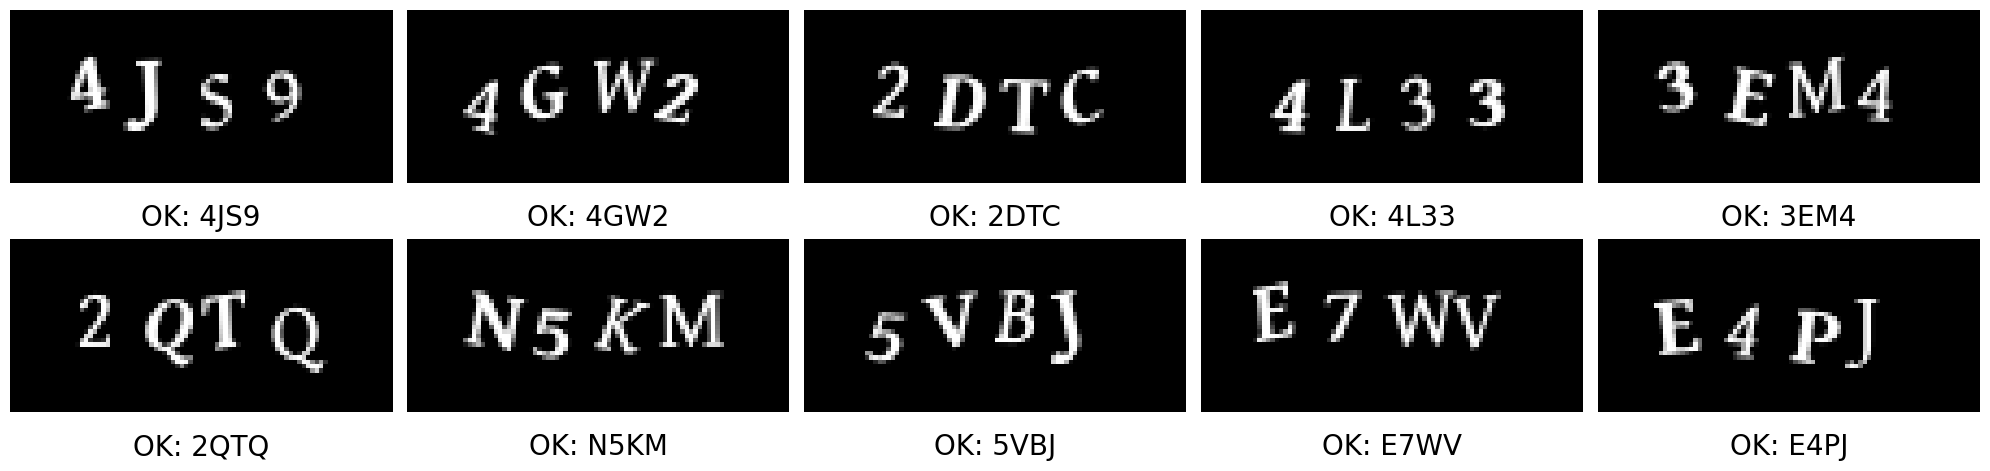

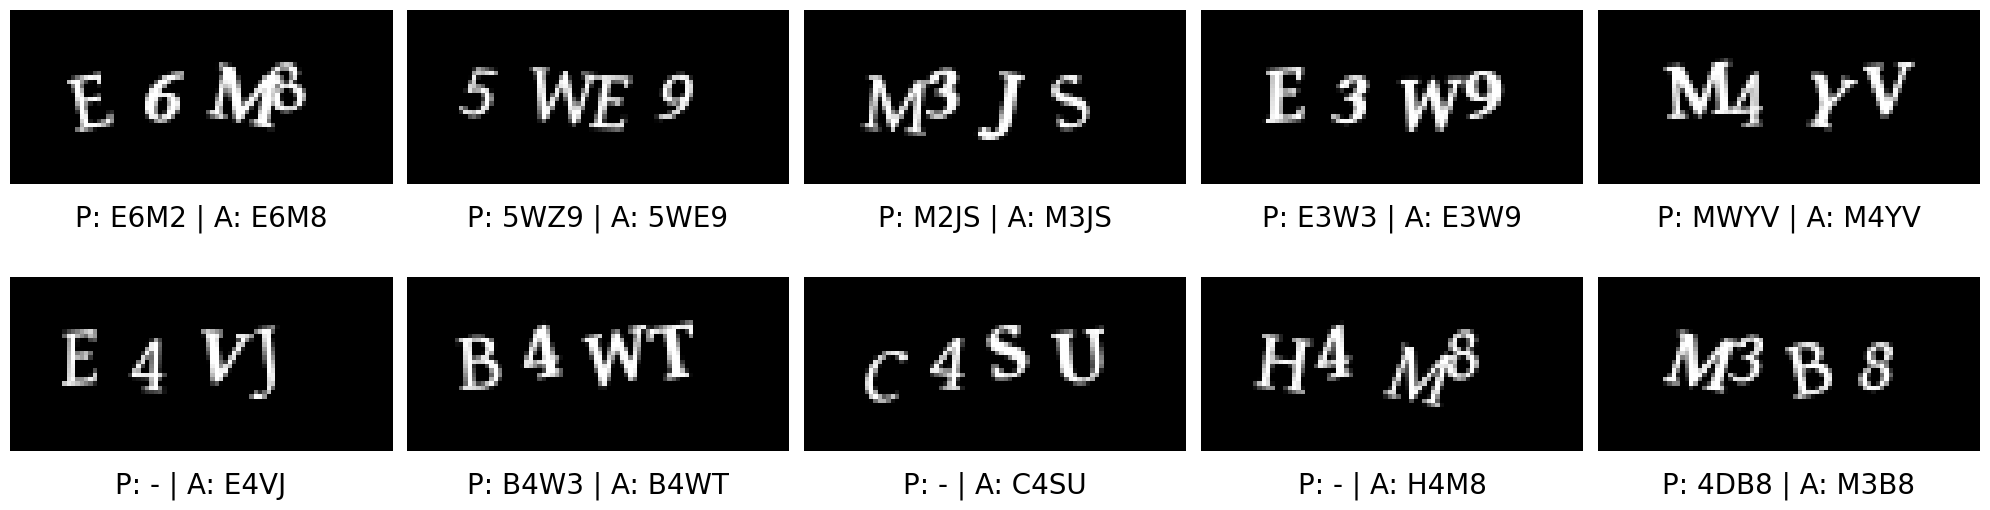

In [14]:
# Constants
N_DISPLAY_SAMPLES = 10
n_test = len(captcha_texts_test)
n_correct = 0
correct_indices = []
incorrect_indices = []

# Calculate accuracy
for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text == actual_text:
        n_correct += 1
        if len(correct_indices) < N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        if len(incorrect_indices) < N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

print(f"Total Test CAPTCHAs: {n_test}")
print(f"Correctly Recognized: {n_correct}")
print(f"Accuracy: {n_correct/n_test:.2%}\n")

# Display results
print("--- Correct Samples ---")
print_images([captcha_images_test[i] for i in correct_indices], 
             texts=[f"OK: {captcha_texts_test[i]}" for i in correct_indices], n_rows=2)

if incorrect_indices:
    print("\n--- Incorrect Samples ---")
    print_images([captcha_images_test[i] for i in incorrect_indices], 
                 texts=[f"P: {preds_test[i]} | A: {captcha_texts_test[i]}" for i in incorrect_indices], 
                 n_rows=2, fig_size=(20, 6))